In [154]:
# DataFrames and Math
import pandas as pd
import numpy as np
import tqdm
pd.options.display.max_columns = 100

# API management
import json
import base64
import requests
from getpass import getpass

# Plotting
import matplotlib.pyplot as plt

# Plotting
import matplotlib.pyplot as plt
from matplotlib import colors
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator, PercentFormatter)

# Paths
import pathlib
data_output_path = pathlib.Path().resolve().parent.parent / "data" / "advan_data"
footfall_output_path = pathlib.Path().resolve().parent.parent / "data" / "advan_data_footfall"
processed_output_path = pathlib.Path().resolve().parent.parent / "data" / "advan_data_processed"

# Define required functions

In [62]:
# Define a helper function to download advan data
def download_advan_data(url, partition, output_path):
    # Get Raja's access token
    access_token = getpass("Enter the access token: ")

    # Get the links to download individual files
    results = requests.get(url=url,
                       headers={
                        "X-API-KEY": access_token,
                        'accept': 'application/json'
                       })

    # Download the files we want
    # Download all files for one month
    for item in results.json()['download_links']:
        if item['partition_key'] == partition:
            filename = item['file_name']
            print(f"Downloading {filename}")
            link = item['link']
            data = requests.get(link)
            open(output_path / filename, 'wb').write(data.content)

In [61]:
def extract_ct_data(input_path, output_path, output_name):
    # Create blank data frame
    ct_data = pd.DataFrame([])

    # Iterate through all the files in the directory
    for file in input_path.iterdir():
        print(f"Reading file {file.name}")
        # Read the file
        data = pd.read_csv(file)
        # Extract rows for CT
        ct_rows = data[data["REGION"]=="CT"].reset_index(drop=True)
        
        # Update the DataFrame
        ct_data = pd.concat([ct_data, ct_rows]).reset_index(drop=True)

    # Save the master data frame
    print(f"Saving to {output_path}")
    ct_data.to_csv(output_path / f"{output_name}.csv")

    return(ct_data)

In [1]:
def gen_od_matrix(input_data, output_filepath, filename):
    # Create blank OD Matrix
    od_matrix = pd.DataFrame([])

    # Loop through the data
    for index, row in tqdm.tqdm(input_data.iterrows()):
        # Get the area (i.e. the block group)
        destination = str(row["AREA"]).zfill(12)
    
        # These are all the origin destinations
        origins = json.loads(row["DEVICE_HOME_AREAS"])
    
        # Create DF
        origins_df = pd.DataFrame(origins, index = [destination])
        origins_df = origins_df.iloc[[0], origins_df.columns.isin(ct_bg_codes)].sort_index(axis=1)
        od_matrix = pd.concat([od_matrix, origins_df])

    # Final cleanup
    od_matrix = od_matrix.fillna(0)
    od_matrix = od_matrix.sort_index(axis =1)
    od_matrix = od_matrix.sort_index(axis = 0)

    # Save
    od_matrix.to_csv(output_filepath / filename)

    return od_matrix

In [143]:
def plot_od_matrix(data, vmin, vmax, cmap, suptitle, index_to_label = None, labeltext = None, **cbar_kw):
    fig, ax = plt.subplots(nrows = 1, ncols = 1, facecolor = 'whitesmoke')

    divider = make_axes_locatable(ax)
    
    cax = divider.append_axes("right", size = "7%", pad = "10%")

    im = ax.imshow(data, vmin = vmin, vmax = vmax, cmap = cmap)

    ax.set_xlabel("Origin Block Group")
    ax.set_ylabel("Destination Block Group")
    ax.set_title(suptitle)

    if index_to_label:
        ax.set_xticks([index_to_label])
        ax.yaxis.set_ticks([])
        ax.set_xticklabels([labeltext])
        ax.yaxis.set_ticklabels([])
        ax.axvline(index_to_label, color = 'red')
        ax.axhline(index_to_label, color = 'red')

    cbar = ax.figure.colorbar(im, ax = ax, cax=cax, **cbar_kw)
    
    plt.show()

# Create O-D Matrix

In [ ]:
# Import data
# data = ....
# Run gen_od_matrix

## Extract O-D Matrix

## HERE
**Currently we are here - we read in the OD matrix that was earlier saved and go from there**
**Better to create the OD matrix in this file**

In [79]:
# Read in OD Matrix
od_matrix = pd.read_csv(processed_output_path / "od_matrix_110523.csv", index_col =[0])

# Get origins and destinations and make them match by shortening
# Get list of origins
origins = od_matrix.columns.to_list()
origins = [int(x[1:]) for x in origins]

# Get list of destinations
destinations = od_matrix.index.to_list()

# Now make them match - i.e only keep rows for which there is a matching column
od_matrix = od_matrix.loc[origins]

# Now sort it so that the diagonal is correct
od_matrix.sort_index(axis = 1)
od_matrix.sort_index(axis = 0)

# Create copy and convert to numpy
od_matrix_np = od_matrix.copy(deep=True)
od_matrix_np = od_matrix_np.to_numpy()

In [81]:
# Make square, and make a copy with no diagonal (or diagonal set to 0)
od_matrix_np = od_matrix_np[0:2583, 0:2583]
od_matrix_np_nodiag = od_matrix_np.copy()[0:2583, 0:2583]
np.fill_diagonal(od_matrix_np_nodiag, 0)

In [82]:
od_matrix_np_pct = od_matrix_np / np.max(od_matrix_np, axis = 1)
od_matrix_np_pct_nodiag = od_matrix_np_nodiag / np.max(od_matrix_np_nodiag, axis = 1)
od_matrix_np_pct_nodiag_singlemax = od_matrix_np_nodiag / np.max(od_matrix_np_nodiag)

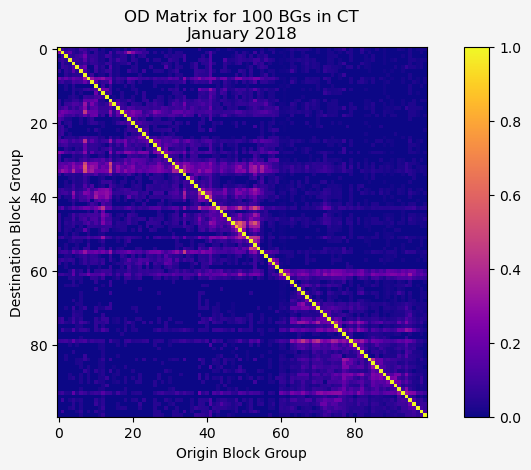

In [152]:
plot_od_matrix(od_matrix_np_pct[0:100, 0:100], 0, 1, 'plasma', 'OD Matrix for 100 BGs in CT\nJanuary 2018')

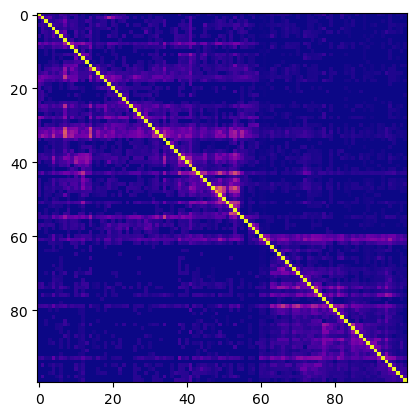

In [84]:
plt.imshow(od_matrix_np_pct[0:100, 0:100], vmin = 0, vmax = 1, cmap = 'plasma')

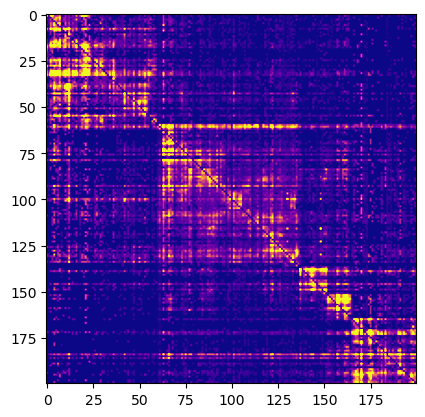

In [85]:
plt.imshow(od_matrix_np_pct_nodiag[0:200, 0:200], vmin = 0, vmax = 1, cmap = 'plasma')

In [68]:
# Get Index of New Haven
od_matrix_blankindex = od_matrix.copy(deep=True).reset_index(drop=False)
od_matrix_blankindex[od_matrix_blankindex["index"]==90091420002].index

Index([1676], dtype='int64')

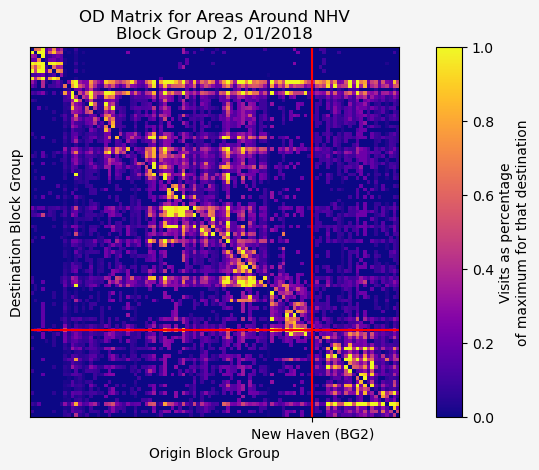

In [153]:
plot_od_matrix(od_matrix_np_pct_nodiag[1600:1700, 1600:1700], 
               0, 1,
               'plasma', 
               'OD Matrix for Areas Around NHV\nBlock Group 2, 01/2018',
               76,
               "New Haven (BG2)",
               label =  "Visits as percentage\nof maximum for that destination")

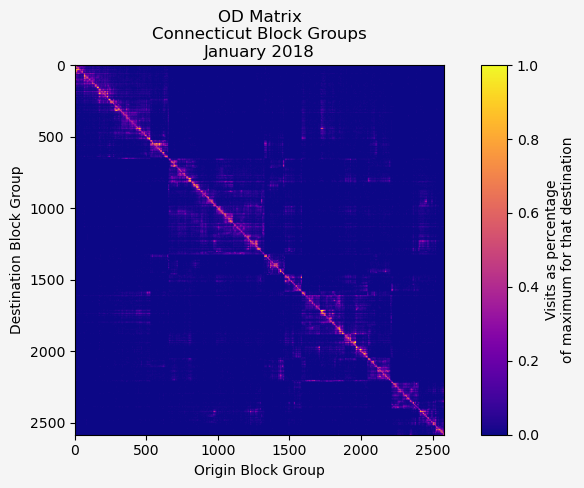

In [150]:
plot_od_matrix(od_matrix_np_pct_nodiag, 
               0, 1,
               'plasma', 
               'OD Matrix\nConnecticut Block Groups\nJanuary 2018',
               label =  "Visits as percentage\nof maximum for that destination")